In [1]:
# Cell 12: load data and predictions for evaluation

import json, joblib, numpy as np, pandas as pd
from pathlib import Path

OUT_DIR = Path(r"C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs")
INT_DIR = OUT_DIR / "interim"
FIG_DIR = OUT_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

Xtr = joblib.load(INT_DIR / "Xtr.pkl")
Xva = joblib.load(INT_DIR / "Xva.pkl")
Xte = joblib.load(INT_DIR / "Xte.pkl")
ytr = joblib.load(INT_DIR / "ytr.npy")
yva = joblib.load(INT_DIR / "yva.npy")
yte = joblib.load(INT_DIR / "yte.npy")

preproc = joblib.load(INT_DIR / "preproc.joblib")
meta = json.load(open(INT_DIR / "meta.json", "r", encoding="utf-8"))

feature_cols = meta["feature_cols"]
num_cols = meta["num_cols"]
bin_cols = meta["bin_cols"]
cat_cols = meta["cat_cols"]

p_logit = joblib.load(INT_DIR / "p_logit.npy")
p_xgb   = joblib.load(INT_DIR / "p_xgb.npy")
p_gnam  = joblib.load(INT_DIR / "p_gnam.npy")
p_final = joblib.load(INT_DIR / "p_final.npy")

print("Test size:", len(yte))


Test size: 476863


,model,AUROC,PR-AUC,Brier,Cal_slope,Cal_intercept,E:O
1,XGBoost,0.729060,0.083586,0.011126,0.996520,0.011106,0.975792
3,GNAM-Boost,0.727245,0.093207,0.011060,1.006497,0.050356,0.977689
2,GNAM,0.714880,0.070861,0.011206,1.011030,0.070436,0.976065
0,Logistic,0.621667,0.023255,0.011519,0.946891,-0.205579,0.972698


Saved table2 to: C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs\table2_model_compare_metrics.csv


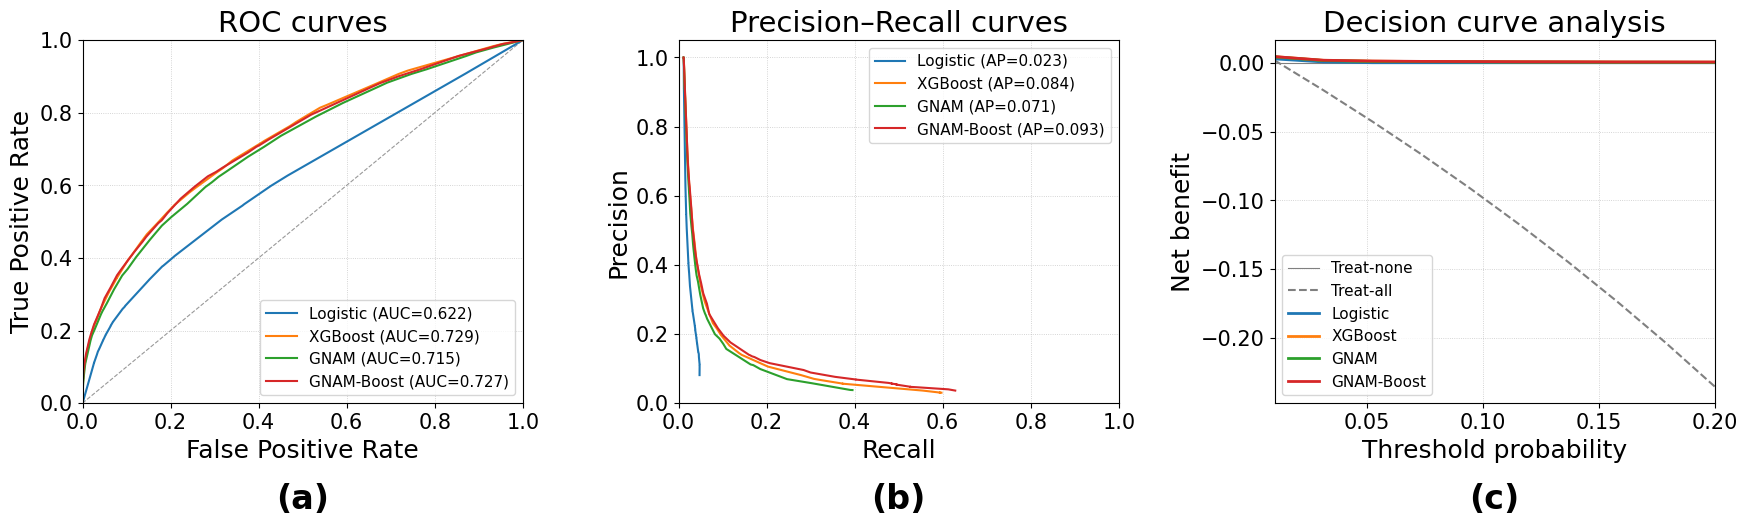

Saved ROC/PR/DCA triptych to: C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs\figs\fig_triptych_roc_pr_dca_dnbr.png


In [6]:
# Cell 13: model performance table and ROC/PR/DCA plots

import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

def _safe_logit(p, eps=1e-12):
    p = np.asarray(p, dtype=float)
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def _fit_calib_lr(z, y):
    try:
        lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000)
        lr.fit(z, y)
    except Exception:
        lr = LogisticRegression(penalty="l2", C=1e6, solver="lbfgs", max_iter=2000)
        lr.fit(z, y)
    return float(lr.coef_[0, 0]), float(lr.intercept_[0])

def calib_slope_intercept(y_true, p_pred):
    y = np.asarray(y_true, dtype=float)
    z = _safe_logit(p_pred).reshape(-1, 1)
    if np.unique(y).size < 2 or np.isfinite(z).sum() != len(z):
        return np.nan, np.nan
    slope, intercept = _fit_calib_lr(z, y)
    return slope, intercept

def expected_over_observed(y_true, p_pred):
    y = np.asarray(y_true, dtype=float)
    p = np.asarray(p_pred, dtype=float)
    E, O = float(np.nansum(p)), float(np.nansum(y))
    return (E / O) if O > 0 else np.nan

def collect_row(name, y, p):
    auroc = float(roc_auc_score(y, p)) if np.unique(y).size > 1 else np.nan
    ap    = float(average_precision_score(y, p)) if np.unique(y).size > 1 else np.nan
    brier = float(brier_score_loss(y, p))
    slope, intercept = calib_slope_intercept(y, p)
    eo = expected_over_observed(y, p)
    return {
        "model": name,
        "AUROC": auroc,
        "PR-AUC": ap,
        "Brier": brier,
        "Cal_slope": slope,
        "Cal_intercept": intercept,
        "E:O": eo,
    }

rows = []
rows.append(collect_row("Logistic",   yte, p_logit))
rows.append(collect_row("XGBoost",    yte, p_xgb))
rows.append(collect_row("GNAM",       yte, p_gnam))
rows.append(collect_row("GNAM-Boost", yte, p_final))

table2 = pd.DataFrame(rows).sort_values("AUROC", ascending=False)
display(table2)

table2_path = OUT_DIR / "table2_model_compare_metrics.csv"
table2.to_csv(table2_path, index=False)
print("Saved table2 to:", table2_path)

# ROC + PR + DCA

def _mask_finite(y, p):
    y = np.asarray(y)
    p = np.asarray(p, dtype=float)
    m = np.isfinite(p)
    return y[m], p[m]

def metrics(y, p):
    y, p = _mask_finite(y, p)
    if y.size == 0 or len(np.unique(y)) < 2:
        return dict(
            auroc=np.nan, ap=np.nan, brier=np.nan,
            roc=(np.array([0, 1]), np.array([0, 1])),
            pr=(np.array([0, 1]), np.array([1, 0])),
        )
    fpr, tpr, _ = roc_curve(y, p)
    rec, prec, _ = precision_recall_curve(y, p)
    return dict(
        auroc=float(roc_auc_score(y, p)),
        ap=float(average_precision_score(y, p)),
        brier=float(brier_score_loss(y, p)),
        roc=(fpr, tpr),
        pr=(rec, prec),
    )

M = {
    "Logistic":   metrics(yte, p_logit),
    "XGBoost":    metrics(yte, p_xgb),
    "GNAM":       metrics(yte, p_gnam),
    "GNAM-Boost": metrics(yte, p_final),
}

COLORS = {
    "Logistic": "#1f77b4",
    "XGBoost": "#ff7f0e",
    "GNAM": "#2ca02c",
    "GNAM-Boost": "#d62728",
}
LW = 1.5

plt.rcParams.update({
    "font.size": 16 * 1.5,
    "axes.titlesize": 14 * 1.5,
    "axes.labelsize": 12 * 1.5,
    "legend.fontsize": 10 * 1.1,
    "xtick.labelsize": 10 * 1.5,
    "ytick.labelsize": 10 * 1.5,
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ROC
ax = axes[0]
ax.plot([0, 1], [0, 1], "--", linewidth=0.8, color="#999999")
for name in ["Logistic", "XGBoost", "GNAM", "GNAM-Boost"]:
    fpr, tpr = M[name]["roc"]
    ax.plot(fpr, tpr,
            label=f"{name} (AUC={M[name]['auroc']:.3f})",
            color=COLORS[name], linewidth=LW)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc="lower right")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

# PR
ax = axes[1]
for name in ["Logistic", "XGBoost", "GNAM", "GNAM-Boost"]:
    rec, prec = M[name]["pr"]
    rec = np.asarray(rec)
    prec = np.asarray(prec)
    prec_plot = np.where(prec < 0.03, np.nan, prec)
    ax.plot(rec, prec_plot,
            label=f"{name} (AP={M[name]['ap']:.3f})",
            color=COLORS[name], linewidth=LW)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall curves")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.legend(loc="upper right")  # <- 图 b 图例挪到右上角
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

# DCA
def decision_curve_net_benefit(y_true, p_pred, thresholds):
    y = np.asarray(y_true, dtype=int)
    p = np.asarray(p_pred, dtype=float)
    N = len(y)
    out = []
    for pt in thresholds:
        pred_pos = (p >= pt).astype(int)
        TP = ((pred_pos == 1) & (y == 1)).sum()
        FP = ((pred_pos == 1) & (y == 0)).sum()
        nb = (TP / N) - (FP / N) * (pt / (1 - pt))
        out.append(nb)
    return np.array(out)

ths = np.linspace(0.01, 0.20, 10)
curves = {
    "Treat-none": np.zeros_like(ths),
    "Treat-all":  [(yte.mean()) - (1 - yte.mean()) * (pt / (1 - pt)) for pt in ths],
    "Logistic":   decision_curve_net_benefit(yte, p_logit, ths),
    "XGBoost":    decision_curve_net_benefit(yte, p_xgb, ths),
    "GNAM":       decision_curve_net_benefit(yte, p_gnam, ths),
    "GNAM-Boost": decision_curve_net_benefit(yte, p_final, ths),
}

ax = axes[2]
ax.axhline(0, color="gray", linewidth=0.8, label="Treat-none")
ax.plot(ths, curves["Treat-all"], color="gray", linestyle="--", label="Treat-all")
for name in ["Logistic", "XGBoost", "GNAM", "GNAM-Boost"]:
    ax.plot(ths, curves[name], color=COLORS[name], label=name, linewidth=2)
ax.set_xlabel("Threshold probability")
ax.set_ylabel("Net benefit")
ax.set_title("Decision curve analysis")
ax.set_xlim(ths.min(), ths.max())
ax.legend(loc="best")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

labels = ["(a)", "(b)", "(c)"]
for i, ax in enumerate(axes):
    ax.text(
        0.5, -0.22, labels[i],
        transform=ax.transAxes,
        fontsize=plt.rcParams["font.size"],
        fontweight="bold",
        ha="center", va="top",
    )

plt.tight_layout()
trip_path = FIG_DIR / "fig_triptych_roc_pr_dca_dnbr.png"
plt.savefig(trip_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("Saved ROC/PR/DCA triptych to:", trip_path)


Shape functions for: ['IDADEMAE', 'SEMAGESTAC', 'PESO']


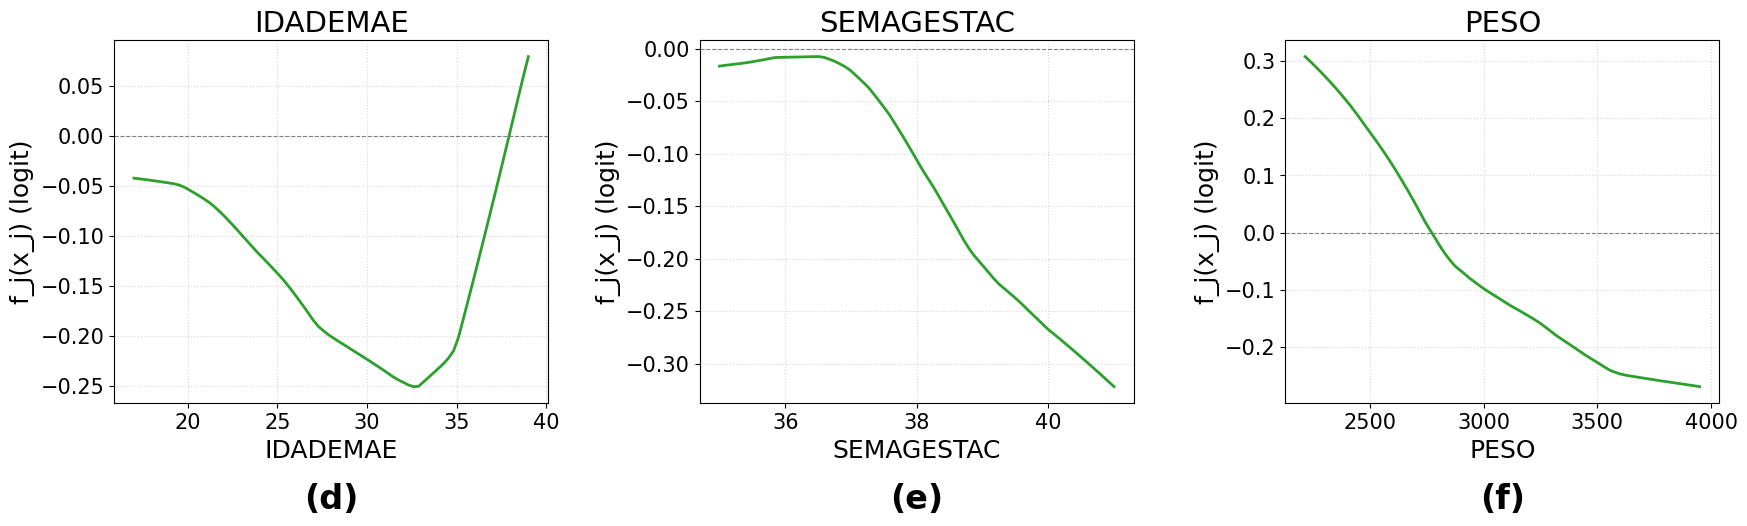

Saved: C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs\figs\shapes\shape_triptych_age_gest_bw.png


In [3]:
# Cell 14: GNAM shape functions (age, gestational age, birthweight)
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from pathlib import Path
import torch.nn as nn, torch.nn.functional as F

# rebuild feature names after preprocessing
try:
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    ohe_names = []

feat_names_full = list(num_cols) + list(bin_cols) + ohe_names
name_to_idx = {n: i for i, n in enumerate(feat_names_full)}

age_var = "IDADEMAE" if "IDADEMAE" in Xtr.columns else None
if age_var is None:
    raise RuntimeError("Age column IDADEMAE not found.")

target_vars = [age_var, "SEMAGESTAC", "PESO"]

# baseline point in transformed space

X_example = preproc.transform(Xtr[feature_cols].iloc[[0]])  # (1, n_features)
Xt_ref = X_example.copy()  # baseline row
n_features = Xt_ref.shape[1]

class ExULayer(nn.Module):
    def __init__(self, nonlin="softplus"):
        super().__init__()
        self.w = nn.Parameter(torch.zeros(1))
        self.b = nn.Parameter(torch.zeros(1))
        self.nonlin = nonlin
    def forward(self, x):
        z = torch.exp(self.w) * (x - self.b)
        if self.nonlin == "softplus":
            return F.softplus(z)
        if self.nonlin == "tanh":
            return torch.tanh(z)
        return F.relu(z)

class FeatureNet(nn.Module):
    def __init__(self, hidden=96, dropout=0.20):
        super().__init__()
        self.exu = ExULayer("softplus")
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden // 2)
        self.fc3 = nn.Linear(hidden // 2, 1)
        self.dp = nn.Dropout(dropout)
    def forward(self, x):
        h = self.exu(x)
        h = F.relu(self.fc1(h))
        h = self.dp(F.relu(self.fc2(h)))
        return self.fc3(h)

class GNAM(nn.Module):
    def __init__(self, n_features, hidden=96, dropout=0.20):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(1))
        self.fnets = nn.ModuleList([FeatureNet(hidden, dropout) for _ in range(n_features)])
    def forward(self, x):
        outs = [self.fnets[j](x[:, j:j+1]) for j in range(x.shape[1])]
        eta = self.bias + torch.stack(outs, dim=2).sum(dim=2)
        return eta.squeeze(1)

gnam = GNAM(n_features=n_features, hidden=96, dropout=0.20)
gnam.load_state_dict(torch.load(INT_DIR / "gnam_best.pt", map_location="cpu"))
gnam.eval()

def _curve_for(var_name, qlow=5, qhigh=95, n_points=80):
    if var_name not in name_to_idx:
        print(f"Feature {var_name} not found in preprocessed features.")
        return None

    raw_vals = pd.to_numeric(Xtr[var_name], errors="coerce").dropna().astype(float)
    if raw_vals.empty:
        print(f"Feature {var_name} has no valid values.")
        return None

    x_raw = np.linspace(
        np.percentile(raw_vals, qlow),
        np.percentile(raw_vals, qhigh),
        n_points,
    )

    j = name_to_idx[var_name]

    if var_name in num_cols:
        idx_in_num = num_cols.index(var_name)
        scaler = preproc.named_transformers_["num"].named_steps["scaler"]
        mu = float(scaler.mean_[idx_in_num])
        sd = float(scaler.scale_[idx_in_num])
        x_std = (x_raw - mu) / (sd + 1e-12)
    else:
        x_std = x_raw

    Xbatch = np.repeat(Xt_ref, len(x_std), axis=0)
    Xbatch[:, j] = x_std

    with torch.no_grad():
        xb = torch.tensor(Xbatch, dtype=torch.float32)
        fj = gnam.fnets[j](xb[:, j:j+1]).squeeze(1).cpu().numpy()

    return x_raw, fj

shape_curves = {}
for v in target_vars:
    res = _curve_for(v)
    if res is not None:
        shape_curves[v] = res
print("Shape functions for:", list(shape_curves.keys()))

def save_triptych(shapes_dict, order, out_path):
    keep = [v for v in order if v in shapes_dict]
    if len(keep) != 3:
        print("Need 3 panels, got:", keep)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.rcParams.update({
        "font.size": 16 * 1.5,
        "axes.titlesize": 14 * 1.5,
        "axes.labelsize": 12 * 1.5,
        "xtick.labelsize": 10 * 1.5,
        "ytick.labelsize": 10 * 1.5,
    })

    for ax, name in zip(axes, keep):
        x, y = shapes_dict[name]
        ax.plot(x, y, color="#2ca02c", linewidth=2)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_axisbelow(True)
        ax.grid(True, which="both", linestyle=":", linewidth=0.8, color="#cccccc", alpha=0.8)
        ax.set_xlabel(name)
        ax.set_ylabel("f_j(x_j) (logit)")
        ax.set_title(name)

    labels = ["(d)", "(e)", "(f)"]
    for i, ax in enumerate(axes):
        ax.text(
            0.5, -0.22, labels[i],
            transform=ax.transAxes,
            fontsize=plt.rcParams["font.size"],
            fontweight="bold",
            ha="center", va="top",
        )

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.tight_layout()
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

triptych_path = FIG_DIR / "shapes" / "shape_triptych_age_gest_bw.png"
order = [age_var, "SEMAGESTAC", "PESO"]
save_triptych(shape_curves, order, triptych_path)
print("Saved:", triptych_path)


F:\Anaconda\envs\gnamboost\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


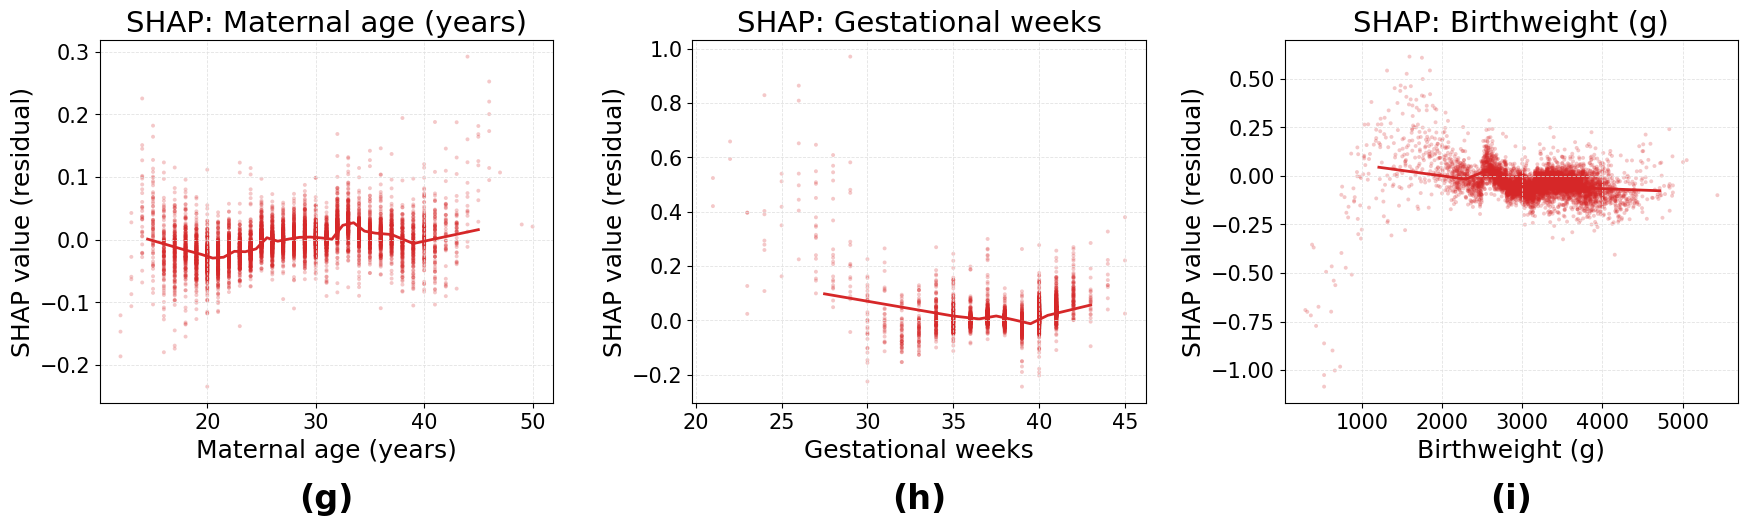

Saved: C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs\figs\fig_shap_residual_age_gest_bw.png


In [4]:
# Cell 15: GNAM-Boost residual SHAP (age, gestational weeks, birthweight)

import numpy as np, matplotlib.pyplot as plt, joblib
from pathlib import Path
import importlib, sys, subprocess
import xgboost as xgb

OUT_DIR = Path(r"C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs")
INT_DIR = OUT_DIR / "interim"
FIG_DIR = OUT_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# load transformed test matrix
Xte_t = joblib.load(INT_DIR / "Xte_t.npy")

# ensure shap
def _ensure(pkg):
    try:
        return importlib.import_module(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        return importlib.import_module(pkg)

shap = _ensure("shap")

# load booster
bst2 = xgb.Booster()
bst2.load_model(str(INT_DIR / "gnamboost_bst.json"))

# feature mapping
try:
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    ohe_names = []

feat_names_full = list(num_cols) + list(bin_cols) + ohe_names
name_to_idx = {n: i for i, n in enumerate(feat_names_full)}

target_vars = ["IDADEMAE", "SEMAGESTAC", "PESO"]

# sample for SHAP
nsamp = min(8000, Xte_t.shape[0])
rng = np.random.RandomState(meta["seed"])
idx = rng.choice(Xte_t.shape[0], size=nsamp, replace=False)
Xte_sample = Xte_t[idx]

explainer = shap.TreeExplainer(bst2)
shap_values = explainer.shap_values(Xte_sample)

plt.rcParams.update({
    "font.size": 16 * 1.5,
    "axes.titlesize": 14 * 1.5,
    "axes.labelsize": 12 * 1.5,
    "xtick.labelsize": 10 * 1.5,
    "ytick.labelsize": 10 * 1.5,
})

label_map = {
    "IDADEMAE": "Maternal age (years)",
    "SEMAGESTAC": "Gestational weeks",
    "PESO": "Birthweight (g)",
}

def _binned_line(x, y, bins=24):
    x = np.asarray(x); y = np.asarray(y)
    if x.size == 0:
        return np.array([]), np.array([])
    qs = np.linspace(0, 1, bins + 1)
    edges = np.quantile(x, qs)
    edges[0] -= 1e-9; edges[-1] += 1e-9
    mids, means = [], []
    for a, b in zip(edges[:-1], edges[1:]):
        m = (x >= a) & (x < b)
        if m.any():
            mids.append((a + b) / 2.0)
            means.append(np.mean(y[m]))
    return np.array(mids), np.array(means)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
labels = ["(g)", "(h)", "(i)"]

for ax, var, lab in zip(axes, target_vars, labels):
    if var not in name_to_idx:
        ax.axis("off")
        continue
    j = name_to_idx[var]
    x_std = Xte_sample[:, j]
    y_shap = shap_values[:, j]

    x_plot = x_std
    if var in num_cols:
        idx_num = num_cols.index(var)
        scaler = preproc.named_transformers_["num"].named_steps["scaler"]
        mu = float(scaler.mean_[idx_num])
        sd = float(scaler.scale_[idx_num])
        x_plot = x_std * sd + mu

    ax.scatter(x_plot, y_shap, s=8, alpha=0.25,
               color="#d62728", edgecolors="none")
    xm, ym = _binned_line(x_plot, y_shap, bins=24)
    if xm.size > 1:
        ax.plot(xm, ym, color="#d62728", linewidth=2)
    ax.grid(True, which="both", linestyle="--", linewidth=0.6,
            color="#e0e0e0", alpha=0.9)
    ax.set_xlabel(label_map.get(var, var))
    ax.set_ylabel("SHAP value (residual)")
    ax.set_title("SHAP: " + label_map.get(var, var))
    ax.text(0.5, -0.22, lab,
            transform=ax.transAxes,
            fontsize=plt.rcParams["font.size"],
            fontweight="bold", ha="center", va="top")

fig.tight_layout()
out_path = FIG_DIR / "fig_shap_residual_age_gest_bw.png"
fig.savefig(out_path, dpi=220, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_path)


Groups: {'Maternal age': 1, 'Gestational weeks': 1, 'Birthweight': 1, 'State': 27, 'Education': 16, 'Race/colour': 6}


,Feature,GNAM_main,XGB_residual,Total
3,State,0.982535,0.031126,1.013660
4,Education,0.211153,0.070508,0.281661
2,Birthweight,0.174762,0.059298,0.234060
1,Gestational weeks,0.163397,0.025602,0.188999
0,Maternal age,0.144325,0.022138,0.166463
5,Race/colour,0.054439,0.031003,0.085442


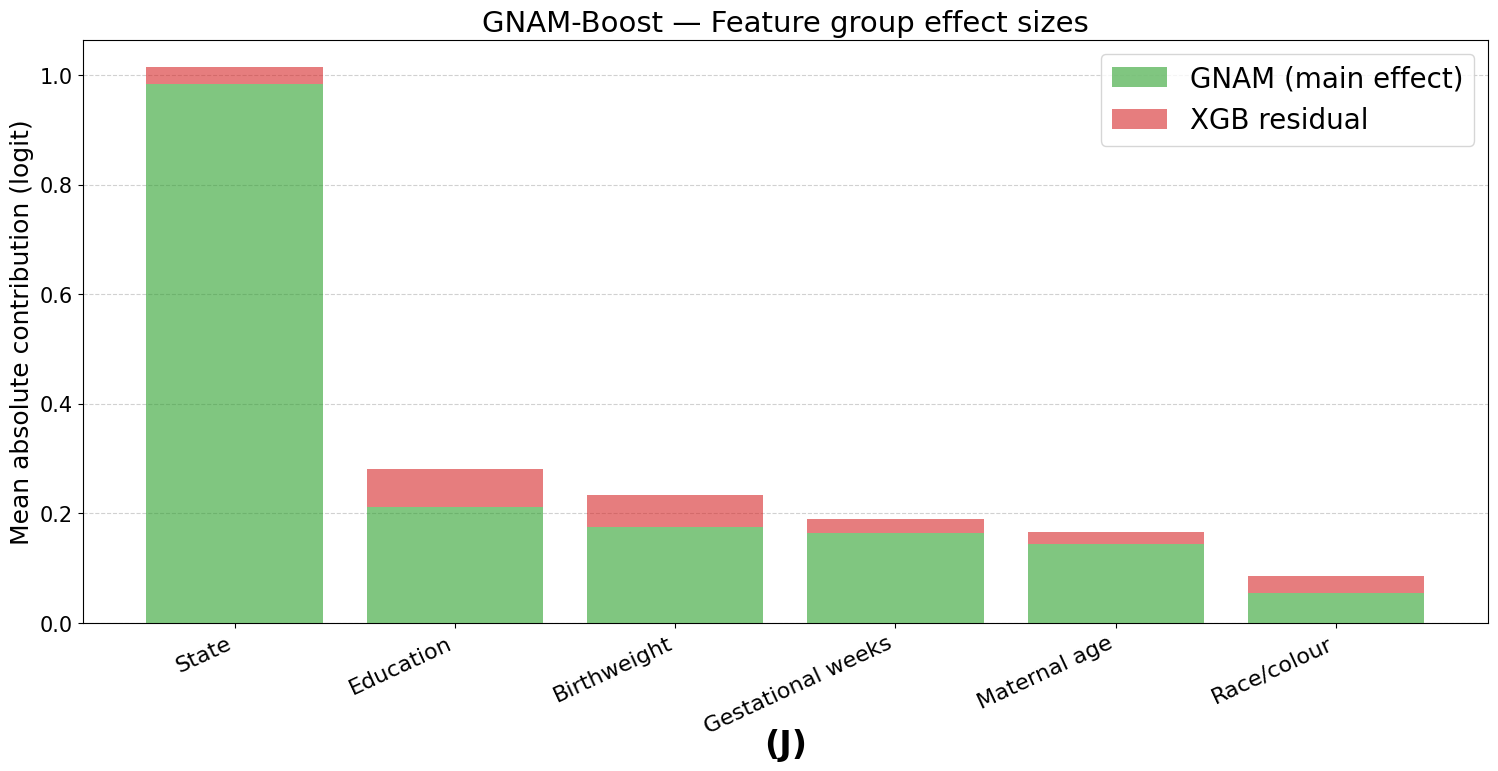

Saved: C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs\figs\fig_gnamboost_effect_sizes_groups_dnbr.png


In [5]:
# Cell 16: GNAM-Boost feature-group effect sizes (Fig J)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path
import importlib, sys, subprocess, joblib
import xgboost as xgb

OUT_DIR = Path(r"C:\Users\Nicee\Desktop\kenkyu\gnamboost_dnbr_outputs")
INT_DIR = OUT_DIR / "interim"
FIG_DIR = OUT_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# reuse Xte_sample and shap_values from Cell 15; if not defined, recompute
if "Xte_sample" not in globals() or "shap_values" not in globals():
    Xte_t = joblib.load(INT_DIR / "Xte_t.npy")
    nsamp = min(8000, Xte_t.shape[0])
    rng = np.random.RandomState(meta["seed"])
    idx = rng.choice(Xte_t.shape[0], size=nsamp, replace=False)
    Xte_sample = Xte_t[idx]

    def _ensure(pkg):
        try:
            return importlib.import_module(pkg)
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
            return importlib.import_module(pkg)
    shap = _ensure("shap")
    bst2 = xgb.Booster()
    bst2.load_model(str(INT_DIR / "gnamboost_bst.json"))
    explainer = shap.TreeExplainer(bst2)
    shap_values = explainer.shap_values(Xte_sample)

# load GNAM again
class ExULayer(nn.Module):
    def __init__(self, nonlin="softplus"):
        super().__init__()
        self.w = nn.Parameter(torch.zeros(1))
        self.b = nn.Parameter(torch.zeros(1))
        self.nonlin = nonlin
    def forward(self, x):
        z = torch.exp(self.w) * (x - self.b)
        if self.nonlin == "softplus":
            return F.softplus(z)
        if self.nonlin == "tanh":
            return torch.tanh(z)
        return F.relu(z)

class FeatureNet(nn.Module):
    def __init__(self, hidden=96, dropout=0.20):
        super().__init__()
        self.exu = ExULayer("softplus")
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden // 2)
        self.fc3 = nn.Linear(hidden // 2, 1)
        self.dp = nn.Dropout(dropout)
    def forward(self, x):
        h = self.exu(x)
        h = F.relu(self.fc1(h))
        h = self.dp(F.relu(self.fc2(h)))
        return self.fc3(h)

class GNAM(nn.Module):
    def __init__(self, n_features, hidden=96, dropout=0.20):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(1))
        self.fnets = nn.ModuleList([FeatureNet(hidden, dropout) for _ in range(n_features)])
    def forward(self, x):
        outs = [self.fnets[j](x[:, j:j+1]) for j in range(x.shape[1])]
        eta = self.bias + torch.stack(outs, dim=2).sum(dim=2)
        return eta.squeeze(1)

Xte_t_full = joblib.load(INT_DIR / "Xte_t.npy")
gnam = GNAM(n_features=Xte_t_full.shape[1], hidden=96, dropout=0.20)
gnam.load_state_dict(torch.load(INT_DIR / "gnam_best.pt", map_location="cpu"))
gnam.eval()

# feature mapping
try:
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    ohe_names = []
feat_names_full = list(num_cols) + list(bin_cols) + ohe_names
name_to_idx = {n: i for i, n in enumerate(feat_names_full)}

def _find_group_indices():
    g = {}
    if "IDADEMAE" in name_to_idx:
        g["Maternal age"] = [name_to_idx["IDADEMAE"]]
    if "SEMAGESTAC" in name_to_idx:
        g["Gestational weeks"] = [name_to_idx["SEMAGESTAC"]]
    if "PESO" in name_to_idx:
        g["Birthweight"] = [name_to_idx["PESO"]]

    state_cols = [c for c in ohe_names if c.startswith("UF_RES")]
    if state_cols:
        g["State"] = [name_to_idx[c] for c in state_cols if c in name_to_idx]
    elif "UF_RES" in name_to_idx:
        g["State"] = [name_to_idx["UF_RES"]]

    edu_cols = [c for c in ohe_names if c.startswith("ESCMAE2010")] + \
               [c for c in ohe_names if c.startswith("ESCMAE")]
    edu_cols = [c for c in edu_cols if c in name_to_idx]
    if edu_cols:
        g["Education"] = [name_to_idx[c] for c in edu_cols]
    elif "ESCMAE2010" in name_to_idx:
        g["Education"] = [name_to_idx["ESCMAE2010"]]

    race_cols = [c for c in ohe_names if c.startswith("RACACOR")]
    race_cols = [c for c in race_cols if c in name_to_idx]
    if race_cols:
        g["Race/colour"] = [name_to_idx[c] for c in race_cols]
    elif "RACACOR" in name_to_idx:
        g["Race/colour"] = [name_to_idx["RACACOR"]]

    if "PARIDADE" in name_to_idx:
        g["Parity"] = [name_to_idx["PARIDADE"]]

    if "KOTELCHUCK" in name_to_idx:
        g["Prenatal care adequacy"] = [name_to_idx["KOTELCHUCK"]]

    if "SEXO" in name_to_idx:
        g["Infant sex"] = [name_to_idx["SEXO"]]

    order = [
        "Maternal age", "Gestational weeks", "Birthweight",
        "State", "Education", "Race/colour", "Parity",
        "Prenatal care adequacy", "Infant sex",
    ]
    return {k: g[k] for k in order if k in g}

group_indices = _find_group_indices()
print("Groups:", {k: len(v) for k, v in group_indices.items()})

def gnam_decompose_in_batches(model, X_mat, batch=2048):
    n, p = X_mat.shape
    parts = np.zeros((n, p), dtype=np.float32)
    with torch.no_grad():
        for start in range(0, n, batch):
            end = min(start + batch, n)
            xb = torch.tensor(X_mat[start:end], dtype=torch.float32)
            chunk = []
            for j in range(p):
                outj = model.fnets[j](xb[:, j:j+1]).squeeze(1).cpu().numpy()
                chunk.append(outj)
            parts[start:end, :] = np.stack(chunk, axis=1)
    bias = float(model.bias.detach().cpu().numpy().reshape(1)[0])
    return bias, parts

# use same sample as SHAP
bias_gnam, parts_sample = gnam_decompose_in_batches(gnam, Xte_sample)

gnam_group_abs = {}
for k, idxs in group_indices.items():
    arr = parts_sample[:, idxs].sum(axis=1) if len(idxs) > 1 else parts_sample[:, idxs[0]]
    gnam_group_abs[k] = float(np.mean(np.abs(arr)))

xgb_group_abs = {}
for k, idxs in group_indices.items():
    arr = shap_values[:, idxs].sum(axis=1) if len(idxs) > 1 else shap_values[:, idxs[0]]
    xgb_group_abs[k] = float(np.mean(np.abs(arr)))

rows = []
for k in group_indices.keys():
    g_main = gnam_group_abs.get(k, 0.0)
    g_res = xgb_group_abs.get(k, 0.0)
    rows.append({
        "Feature": k,
        "GNAM_main": g_main,
        "XGB_residual": g_res,
        "Total": g_main + g_res,
    })

df_eff = pd.DataFrame(rows).sort_values("Total", ascending=False)
display(df_eff)

COLORS = {"GNAM": "#2ca02c", "GNAM-Boost": "#d62728"}

plt.rcParams.update({
    "font.size": 16 * 1.5,
    "axes.titlesize": 14 * 1.5,
    "axes.labelsize": 12 * 1.5,
    "legend.fontsize": 10 * 2,
    "xtick.labelsize": 10 * 1.6,
    "ytick.labelsize": 10 * 1.5,
})

fig, ax = plt.subplots(figsize=(15.5, 8.0))
x = np.arange(len(df_eff))
main = df_eff["GNAM_main"].values
resd = df_eff["XGB_residual"].values

ax.set_axisbelow(True)
ax.grid(True, which="both", axis="y", linestyle="--",
        linewidth=0.8, color="#cccccc", alpha=0.9, zorder=0)

ax.bar(x, main, color=COLORS["GNAM"], alpha=0.6,
       label="GNAM (main effect)", zorder=3)
ax.bar(x, resd, bottom=main, color=COLORS["GNAM-Boost"], alpha=0.6,
       label="XGB residual", zorder=3)

ax.set_xticks(x)
ax.set_xticklabels(df_eff["Feature"], rotation=25, ha="right")
ax.set_ylabel("Mean absolute contribution (logit)")
ax.set_title("GNAM-Boost — Feature group effect sizes")
ax.legend()
fig.tight_layout()
ax.text(0.5, -0.18, "(J)",
        transform=ax.transAxes,
        fontsize=plt.rcParams["font.size"],
        fontweight="bold", ha="center", va="top")

fig_path = FIG_DIR / "fig_gnamboost_effect_sizes_groups_dnbr.png"
plt.savefig(fig_path, dpi=220, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", fig_path)
